In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import signal
from scipy import ndimage
from scipy.ndimage import label, grey_closing
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure
from scipy.ndimage.filters import gaussian_filter
import warnings
from scipy.ndimage import distance_transform_edt as distance
import bottleneck as bn
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression

In [2]:
def identify_pifs(src, ref, clip = True):
    # Canonical correlation analysis is used to identify psuedo-invariant features
    # We assume that phenological or atmospheric differences are linear
    # While land-use change or cloud cover is non-linear
    # We select the points between src and ref that are the most correlated
    # By doing CCA and selecting the pixels where the components are the closest
    cca = CCA(n_components=2, tol=1e-6, max_iter=500)
    xs, ys = cca.fit_transform(src[..., :10], ref[..., :10])

    # Empirically, only looking at the 5-95% of PIFs improves data quality
    xmin = np.percentile(xs, 5, axis = 0)
    ymin = np.percentile(ys, 5, axis = 0)
    xmax = np.percentile(xs, 95, axis = 0)
    ymax = np.percentile(ys, 95, axis = 0)
    xs = (xs - xmin) / (xmax - xmin)
    ys = (ys - ymin) / (ymax - ymin)
    
    diffs = xs - ys
    # Mean squared difference, select px in bottom 20%
    diffs = np.sum((diffs / np.std(diffs, axis=0))**2, axis=1)
    diffs = np.argwhere(diffs < np.percentile(diffs, 10))

    pif_src = src[diffs].squeeze()
    pif_ref = ref[diffs].squeeze()
    return pif_src, pif_ref

In [3]:
def make_aligned_mosaic(arr, interp):
    bands = arr.shape[-1]

    def _ndwi(arr):
        return (arr[..., 1] - arr[..., 3]) / (arr[..., 1] + arr[..., 3])
    
    # Create a water mask to do mosaic creating separately for areas over water
    water_mask = np.median(_ndwi(arr), axis=0)
    water_mask = water_mask > 0
    water_mask = binary_dilation(1 - water_mask, iterations=2)
    water_mask = binary_dilation(1 - water_mask, iterations=5)

    non_interp_areas = arr[np.logical_and(interp == 0, water_mask == 0)]

    mosaic = np.zeros((arr.shape[1], arr.shape[2], arr.shape[3]),
                      dtype=np.float32)
    divisor = (np.sum(1 - interp, axis=0))[..., np.newaxis]
    brightness_mask = bn.nanmax(np.sum(arr[..., :3], axis = -1), axis = 0)

    for i in range(arr.shape[0]):

        # All areas within one image that are not interpolated
        non_interp_mosaic = arr[i][np.logical_and(interp[i] < 1,
                                                    water_mask == 0)]
        non_interp_areas = np.full((arr.shape[1], arr.shape[2], arr.shape[3]), 0, dtype = np.float32)
        non_interp_count = np.full((arr.shape[1], arr.shape[2], arr.shape[3]), 0, dtype = np.float32)

        for b in range(arr.shape[0]):
            if b != i:
                mask = np.logical_and(np.logical_and(interp[i] < 1, interp[b] < 1),
                                            water_mask == 0)
                arr_b = arr[b]
                non_interp_areas[mask] += arr_b[mask]
                non_interp_count[mask] += 1
        non_interp_areas = non_interp_areas / non_interp_count
        non_interp_areas = np.reshape(non_interp_areas, (non_interp_areas.shape[0] * non_interp_areas.shape[1], non_interp_areas.shape[2]))
        non_interp_areas = non_interp_areas[~np.isnan(non_interp_areas).any(axis=1)]

        if non_interp_mosaic.shape[0] > 1000 and non_interp_areas.shape[0] > 1000:
            non_interp_mosaic = non_interp_mosaic[:non_interp_areas.shape[0]]
            non_interp_areas = non_interp_areas[:non_interp_mosaic.shape[0]]
            non_interp_mosaic, non_interp_areas_i = identify_pifs(
                        non_interp_mosaic, non_interp_areas)

            mean_ref = bn.nanmean(non_interp_areas, axis=0)
            std_ref = bn.nanstd(non_interp_areas, axis=0)

            mean_src = bn.nanmean(non_interp_mosaic, axis=0)
            std_src = bn.nanstd(non_interp_mosaic, axis=0)

            higher = np.argwhere(mean_src >= mean_ref)
            lower = np.argwhere(mean_src < mean_ref)


            std_mult = (std_ref / std_src)
            addition = (mean_ref - (mean_src * (std_mult)))
            arr_i = np.copy(arr[i])
            arr_i[water_mask == 0] = arr_i[water_mask == 0] * std_mult + addition
            increment = (1 - interp[i][..., np.newaxis]) * arr_i
            # We want to not include pixels that are the brightest or the least bright
            # if there are >3 images
            #areas_to_subset = divisor >= 3
            #is_max_brightness = np.sum(arr[i, ..., :3], axis = -1) == brightness_mask
            #is_min_brightness = np.sum(arr[i, ..., :3], axis = -1) == darkness_mask
            #areas_to_subset = areas_to_subset.squeeze() * (is_min_brightness + is_max_brightness)
            #print(i, np.mean(areas_to_subset))
            #increment[areas_to_subset] = 0.
            #divisor[areas_to_subset] -= 1.
            mosaic = mosaic + increment
            
        else:
            interp[i] = 1.
    divisor[divisor < 0] = 0.
    mosaic = mosaic / divisor
    mosaic[np.isnan(mosaic)] = np.percentile(arr, 10, axis=0)[np.isnan(mosaic)]
    mins = np.min(arr, axis = 0)
    maxs = np.max(arr, axis = 0)
    mosaic = np.maximum(mosaic, mins)
    mosaic = np.minimum(mosaic, maxs)
    #divisor = (np.sum(1 - (interp > 0.5), axis=0))[..., np.newaxis] >= 3
    #divisor = divisor.repeat(10, axis = -1)

    #mins = np.percentile(arr, 25, axis = 0)
    #maxs = np.percentile(arr, 75, axis = 0)
    #print(divisor.shape, mins.shape, maxs.shape)
    #mosaic[divisor] = np.maximum(mosaic[divisor], mins[divisor])
    #mosaic[divisor] = np.minimum(mosaic[divisor], maxs[divisor])
    #mosaic = np.clip(mosaic, 0, np.max(mosaic))
    #np.save("mosaic.npy", mosaic)
    return mosaic

In [4]:
import sklearn.ensemble
def align_interp_array(interp_array,
                       array,
                       date,
                       interp,
                       mosaic,
                       water_mask,
                       linregress=False):
    # Normalizes interpolated areas to non-interpolated areas
    # By learning linear mappings based on pseudo-invariant features
    # And smoothly blending with a gaussian filter

    #def _identify_interp():
    #    non_interp_mosaic, non_interp_areas = identify_pifs(
    #                non_interp_mosaic, non_interp_areas)
    bands = array.shape[-1]
    for time in range(1):

        if np.sum(interp[date] > 0) > 0 and np.sum(interp[date] == 0) > 0:
            if np.mean(np.logical_and(interp[date] < 1, water_mask == 0)) > 0.01:
                interp_map = interp[date, ...]
                interp_all = interp_map
                array_i = array[date]
                interp_array_i = interp_array[time]

                # Identify all of the areas that are, and aren't interpolated
                # interp_areas = interp_array_i[np.logical_and(interp[time] > 0, water_mask == 0)]
                non_interp_areas = []
                non_interp_mosaic = []

                # For the date prior, the date, and the date after
                min_time = np.maximum(date - 1, 0)
                max_time = np.minimum(date + 2, array.shape[0])

                max_noninterp = np.zeros((array.shape[1], array.shape[2], array.shape[3]))
                min_noninterp = np.ones((array.shape[1], array.shape[2], array.shape[3]))
                for t in range(array.shape[0]):
                    noninterp_i = np.copy(array[t])
                    noninterp_i[interp[t] >= 0.5] = np.nan
                    max_noninterp[noninterp_i > max_noninterp] = noninterp_i[noninterp_i > max_noninterp]
                    min_noninterp[noninterp_i < min_noninterp] = noninterp_i[noninterp_i < min_noninterp]
                
                # Calculate how many cloud free pixels there are for the date in question
                n_current_time = np.sum(np.logical_and(
                        interp[date] < 0.5, water_mask == 0))

                # For the date prior, the date, and the date after
                for t in range(min_time, max_time):
                    # Look for all non-interp, non-water pixels
                    requirement1 = np.logical_and(
                        interp[t] < 0.5, water_mask == 0)
                    # That are in the 90% bounds
                    upper = np.percentile(array[t, ..., 3], 95)
                    lower = np.percentile(array[t, ..., 3], 5)
                    requirement2 = np.logical_and(array[t, ..., 3] >= lower, 
                        array[t, ..., 3] <= upper)

                    non_interp_areasi = array[t][np.logical_and(
                        requirement1, requirement2)][:n_current_time]
                    # The non_interp_mosaic are those pixels in the mosaic
                    # That were not interpolated in time t-1 to t+2
                    non_interp_mosaici = mosaic[np.logical_and(
                        requirement1, requirement2)][:n_current_time]

                    non_interp_areas.append(non_interp_areasi)
                    non_interp_mosaic.append(non_interp_mosaici)

                idx = 1 if non_interp_mosaic[1].shape[0] > 2 else 0

                non_interp_mid_mosaic = non_interp_mosaic[idx]
                non_interp_mid_areas = non_interp_areas[idx]
                random_sample = np.arange(0, 5000, 1)
                
                random_sample = random_sample[:non_interp_mid_mosaic.shape[0]]
                random_sample = random_sample[:non_interp_mid_areas.shape[0]]
                random.shuffle(random_sample)
                
                non_interp_mid_mosaic = non_interp_mid_mosaic[random_sample]
                non_interp_mid_areas = non_interp_mid_areas[random_sample]
                #non_interp_mid_mosaic, non_interp_mid_areas = identify_pifs(
                #    non_interp_mid_mosaic, non_interp_mid_areas)

                #non_interp_mosaic = np.concatenate(non_interp_mosaic, axis = 0)
                #non_interp_areas = np.concatenate(non_interp_areas, axis = 0)

                #non_interp_mosaic, non_interp_areas = identify_pifs(
                #    non_interp_mosaic, non_interp_areas)
                

                if linregress:
                    # Learn a linear mapping with OLS. Empirically thihs does not seem to work better
                    # Than a simple mean / std deviation shift (below), which is the default
                    for band in range(10):
                        min_band = np.min(array[..., 0], axis = 0)
                        model = sklearn.ensemble.HistGradientBoostingRegressor().fit(
                            X = non_interp_mid_mosaic,
                            y = non_interp_mid_areas[..., band])
                        
                        predicted = np.copy(interp_array_i)
                        predicted = np.reshape(predicted, (predicted.shape[0]*predicted.shape[1], 10))
                        predicted = model.predict(predicted)
                        predicted = np.reshape(predicted, interp_array_i.shape[:-1])
                        
                        #predicted[predicted < min_band] = min_band[predicted < min_band]
                        
                        interp_array_i[np.logical_and(
                            interp[date] > 0,
                            water_mask == 0), band] = predicted[np.logical_and(
                                interp[date] > 0, water_mask == 0)]

                        interp_array[time] = interp_array_i
    return interp_array

In [483]:
import random
def remove_cloud_and_shadows(tiles: np.ndarray,
                             probs: np.ndarray,
                             shadows: np.ndarray,
                             image_dates,
                             pfcps,
                             wsize: int = 36,
                             step=8,
                             thresh=100) -> np.ndarray:
    """ Interpolates clouds and shadows for each time step with
        linear combination of proximal clean time steps for each
        region of specified window size

        Parameters:
         tiles (arr):
         probs (arr):
         shadows (arr):
         image_dates (list):
         wsize (int):

        Returns:
         tiles (arr):
    """

    areas_interpolated = np.copy(probs)
    areas_interpolated = areas_interpolated.astype(np.float32)
    
    for date in range(areas_interpolated.shape[0]):
        if np.sum(areas_interpolated[date]) > 0:
            blurred = distance(1 - areas_interpolated[date])
            blurred[blurred > 16] = 16
            blurred = (blurred / 16)
            blurred = 1 - blurred
            blurred[blurred < 0.1] = 0.
            blurred = grey_closing(blurred, size=20)
            areas_interpolated[date] = blurred

    areas_interpolated = areas_interpolated.astype(np.float32)
    
    mosaic = make_aligned_mosaic(tiles, areas_interpolated)

    def _water_ndwi(array):
        return (array[..., 1] - array[..., 3]) / (array[..., 1] + array[..., 3])

    water_mask = _water_ndwi(np.median(tiles, axis=0)) > 0.0
    to_remove = []
    for date in range(0, tiles.shape[0]):
        interp_array = np.zeros_like(tiles[date])
        interp_multiplier = (1 - areas_interpolated[date, ..., np.newaxis])
        interp_array[areas_interpolated[date] > 0] = mosaic[
            areas_interpolated[date] > 0]
        interp_array = align_interp_array(interp_array[np.newaxis],
                                          tiles,#tiles[date][np.newaxis],
                                          date,
                                          areas_interpolated,#[date][np.newaxis],
                                          mosaic, water_mask, True)
        print(np.min(interp_array, axis = (0, 1, 2)))
        tiles[date] = (tiles[date] * (1 - areas_interpolated[date][..., np.newaxis]) +  \
                      (interp_array * areas_interpolated[date][..., np.newaxis]))
        if np.mean(areas_interpolated[date] == 1) == 1:
            to_remove.append(date)

    areas_interpolated = areas_interpolated[..., np.newaxis]
    interp_array = None
    areas_interpolated = areas_interpolated.squeeze()
    #clouds_in_mosaic = calculate_clouds_in_mosaic(mosaic,
    #                                              areas_interpolated.squeeze(),
    #                                              pfcps)
    #areas_interpolated += clouds_in_mosaic[np.newaxis]
    areas_interpolated[areas_interpolated > 1] = 1.

    #p.save("right_interp.npy", areas_interpolated)
    return tiles, areas_interpolated, to_remove, mosaic

In [56]:
sentinel2 = np.load("../../src/before.npy")
cloudshad = np.load("../../src/cloudshad.npy")
image_dates = np.load("../../src/image_dates.npy")
fcps = np.load("../../src/fcps.npy")

In [485]:
sentinel2, interp, to_remove, mosaic = remove_cloud_and_shadows(
                sentinel2, cloudshad, cloudshad, image_dates,
                 pfcps = fcps, 
                 wsize = 8, 
                 step = 8,
                thresh = 4
            )

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


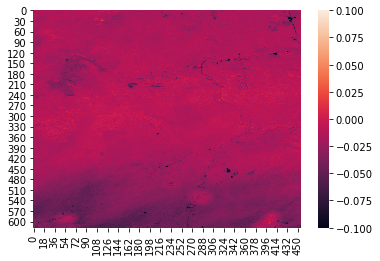

In [512]:
l = np.diff(sentinel2, axis = 0)
sns.heatmap(l[4, ..., 0], vmax = 0.1, vmin = -0.1)

In [12]:

cloudshad.shape

(6, 618, 408)

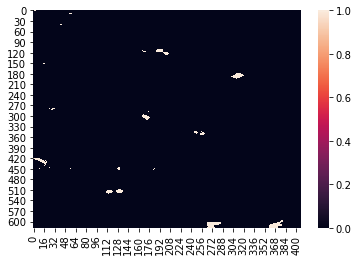

In [21]:
sns.heatmap((np.sum(cloudshad, axis = 0) / 6) > 0.5)

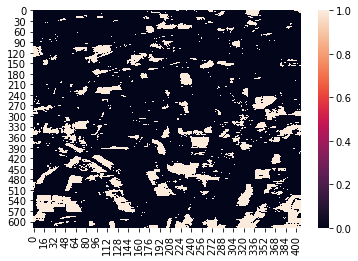

In [51]:
sns.heatmap((sentinel2[2,..., 3] / (sentinel2[2, ..., 8])) < 1.25)

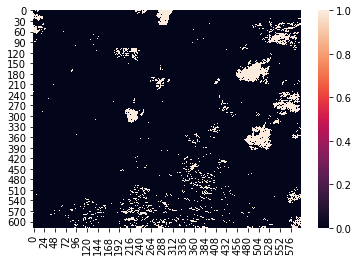

In [73]:
sns.heatmap(sentinel2[4, ..., 0] > (sentinel2[4, ..., 1] - 0.01))

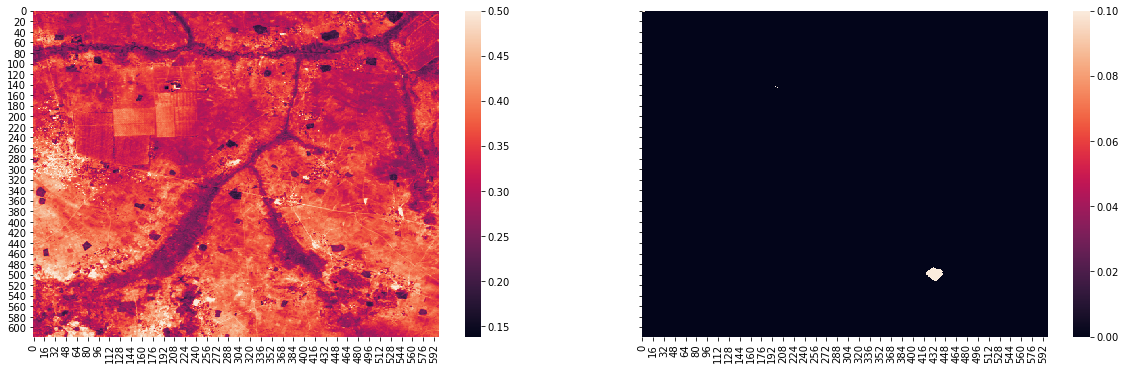

In [76]:
fig, axs = plt.subplots(ncols=2, figsize = (20, 6), sharey = True)
sns.heatmap(np.sum(sentinel2[7, ..., :3], axis = -1), ax = axs[0], vmax = 0.5)
sns.heatmap(cloudshad[7, ...], ax = axs[1], vmax = 0.1)

In [446]:
for i in range(sentinel2.shape[0]):
    print(np.corrcoef(sentinel2[i][cloudshad[i] == 0][:, 2].flatten(),
                      sentinel2[i][cloudshad[i] == 0][:, 3].flatten())[1, 0])

0.21555167884442733
-0.005583534185110919
-0.40355334562230766
-0.36733125512971504
-0.15860502626727882
0.6035048014790656
0.28583584509821264


In [481]:
# OLD METHOD
for i in range(sentinel2.shape[0]):
    print(np.corrcoef(sentinel2[i,..., 2].flatten(),
                      sentinel2[i,..., 3].flatten())[1, 0])

0.4733373889030662
-0.012133584423956591
-0.40104236931308923
-0.33619106141762944
-0.15438522291576598
0.674357810511236
0.35573539031648715


In [343]:
# multiband linear regression
for i in range(sentinel2.shape[0]):
    print(np.corrcoef(sentinel2[i,..., 2].flatten(),
                      sentinel2[i,..., 3].flatten())[1, 0])

0.40687290306135976
0.3296021584142343
-0.17638537463695084
-0.22577372447010136
-0.1597222659729081
0.9373080629541026
0.5677773902107633


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


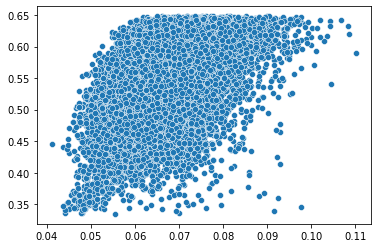

In [344]:
# Multiband linear regression
non_interp_areas = np.load("non_interp_areas.npy")
non_interp_mosaic = np.load("non_interp_mosaic.npy")


sns.scatterplot(non_interp_areas[..., 1], non_interp_areas[..., 3])

In [264]:
model = LinearRegression().fit(
    X = non_interp_mosaic,
    y = non_interp_areas[..., 0][..., np.newaxis])
#model.coef_ = model.coef_.reshape((1, 10))
#model.intercept_ = model.intercept_.reshape((1, 10))

adjustor = np.sum((model.coef_ * non_interp_mosaic), axis = 1)# + (model.intercept_)
#adjustor = np.sum()

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


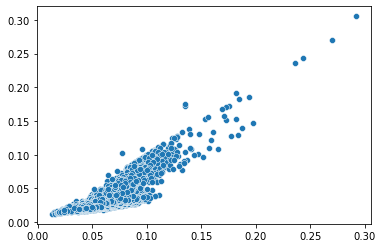

In [410]:
sns.scatterplot(sentinel2[3, ..., 1].flatten(), sentinel2[3, ..., 0].flatten())

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


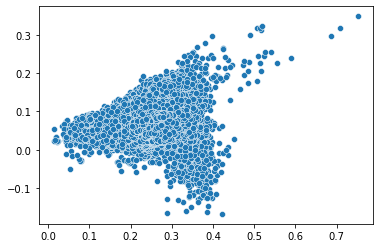

In [328]:
sns.scatterplot(sentinel2[0, ..., 3].flatten(), sentinel2[0, ..., 2].flatten())

In [329]:
np.min(sentinel2[0], axis = (0, 1))

array([-6.75578266e-02,  1.14942342e-02, -1.66866332e-01,  1.35042341e-02,
       -7.27219954e-02, -1.67943351e-03, -1.06597096e-01,  2.00094227e-02,
       -9.10214722e-01, -1.82535684e+00], dtype=float32)